In [1]:
#----------------standard packages-------------------
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#-----------------caio's modules---------------------
import sys, os #add code folder to sys.path
sys.path.append(os.path.abspath(os.path.join('../data_processing')))

from cricsheet_read import cricsheet_read #data processing

#-------------------ML packages---------------------
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as xgb
#import xgboost as xgb

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc

wrangle_data = pd.read_csv('../../data/player_data.csv', dtype = {'match_id':str},
                           parse_dates = ['start_date']).set_index('match_id')

wrangle_data['start_date'] = wrangle_data['start_date'].dt.date

results = cricsheet_read()[1].drop('toss_winner', axis = 1)
results = results.join(pd.read_csv('../../data/betfair_data.csv',dtype = {'match_id':str}).set_index('match_id'))

In [7]:
#-------test-train split and one-hot encode---------
def chrono_split_encode(wrangle_data, test_date, encode = True):
    
    test_date = dt.datetime.strptime(test_date, '%Y-%m-%d').date()

    X = wrangle_data.drop(['set_team_win'], axis = 1).reset_index(drop = True)
    y = wrangle_data[['set_team_win', 'start_date']]
    
    if encode == True:
        non_enconding = ['set_team_toss', 'days_since_match', 'start_date']
        
        encoder = OneHotEncoder()
        X = X[non_enconding].join(pd.DataFrame(encoder.fit_transform(X.drop(non_enconding, axis = 1)).toarray()))
        X.columns = X.columns.map(str)
    
    X_train = X[X['start_date'] < test_date].copy().drop('start_date', axis = 1)
    X_test = X[X['start_date'] >= test_date].copy().drop('start_date', axis = 1)

    y_train = y[y['start_date'] < test_date].copy()['set_team_win']
    y_test =  y[y['start_date'] >= test_date].copy()['set_team_win']
    
    return X_train, X_test, y_train, y_test
#---------------------------------------------------
X_train, X_test, y_train, y_test = chrono_split_encode(wrangle_data, '2020-01-01')

              precision    recall  f1-score   support

       False       0.67      0.81      0.73       362
        True       0.75      0.58      0.66       350

    accuracy                           0.70       712
   macro avg       0.71      0.70      0.70       712
weighted avg       0.71      0.70      0.70       712

chasing team always wins: roc auc = 0.500
model prediction: roc auc = 0.777


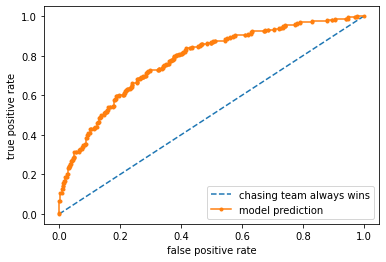

,start_date,league,venue,match_name,set_team,chase_team,result,set_odds,chase_odds,set_prob,chase_prob,set_value,chase_value
match_id,,,,,,,,,,,,,
1207702,2020-08-27,Vitality Blast,Riverside Ground,Lancashire v Durham,Lancashire,Durham,Lancashire,1.99,2.14,0.504753,0.495247,0.004459,0.059828
1207707,2020-08-29,Vitality Blast,Riverside Ground,Durham v Nottinghamshire,Durham,Nottinghamshire,Nottinghamshire,3.10,1.45,0.579400,0.420600,0.796139,-0.390129
1207710,2020-08-29,Vitality Blast,"County Ground, New Road",Worcestershire v Northamptonshire,Worcestershire,Northamptonshire,Northamptonshire,1.79,2.26,0.435468,0.564532,-0.220512,0.275841
1207711,2020-08-29,Vitality Blast,County Ground,Glamorgan v Gloucestershire,Glamorgan,Gloucestershire,Glamorgan,2.36,1.74,0.503710,0.496290,0.188754,-0.136455
1207712,2020-08-30,Vitality Blast,County Ground,Hampshire v Sussex,Hampshire,Sussex,Sussex,3.90,1.34,0.136757,0.863243,-0.466646,0.156745
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233955,2020-11-29,T20 Internationals,Bay Oval,New Zealand v West Indies,New Zealand,West Indies,New Zealand,1.75,2.30,0.257436,0.742564,-0.549487,0.707898
1277976,2021-11-22,T20 Internationals,"Shere Bangla National Stadium, Mirpur",Bangladesh v Pakistan,Bangladesh,Pakistan,Pakistan,4.40,1.29,0.498245,0.501755,1.192280,-0.352737
1287773,2021-12-13,T20 Internationals,"National Stadium, Karachi",Pakistan v West Indies,Pakistan,West Indies,Pakistan,1.28,4.50,0.434330,0.565670,-0.444058,1.545517


In [40]:
#-------------------player model--------------------
def player_model(X_train, X_test, y_train, y_test, results, algorithm = 'forest', metrics = False):
#-------------------scaling-------------------------
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
    
#------------------algorithms-----------------------      
    if algorithm == 'xgb':
        model = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
        model.fit(X_train,y_train)
    else:
        model = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1,
                                       max_features = 'auto', max_depth = 100, bootstrap = True)
        model.fit(X_train, y_train)
    
#---------------value calculations------------------
    test_data = results[results.index.isin(y_test.index)].copy()
    test_data['set_prob'] = model.predict_proba(X_test)[:,1]
    test_data['chase_prob'] = model.predict_proba(X_test)[:,0]
    test_data['set_value'] = test_data['set_prob']*test_data['set_odds'] - 1
    test_data['chase_value'] = test_data['chase_prob']*test_data['chase_odds'] - 1

    if metrics == False:
        return model, test_data
    
#-------------------metrics-------------------------    
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))

    false_auc = roc_auc_score(y_test, y_test.clip(upper = False))
    model_auc = roc_auc_score(y_test, test_data['set_prob'])
    
    print('chasing team always wins: roc auc = %.3f' % (false_auc))
    print('model prediction: roc auc = %.3f' % (model_auc))
    
    false_fpr, false_tpr, _ = roc_curve(y_test, y_test.clip(upper = False))
    model_fpr, model_tpr, _ = roc_curve(y_test, test_data['set_prob'])

    plt.plot(false_fpr, false_tpr, linestyle = '--', label = 'chasing team always wins')
    plt.plot(model_fpr, model_tpr, marker = '.', label = 'model prediction')

    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend()
    plt.show()
    
    if model == 'xgb':
        xgb.plot_importance(clf,importance_type='weight')
        plt.show()
        print(pd.DataFrame.from_dict(clf.get_booster().get_fscore(),
                                     orient = 'index').sort_values(0, ascending = False).head(10))  
    return model, test_data
#---------------------------------------------------
player_model(X_train, X_test, y_train, y_test, results, algorithm = 'forest', metrics = True)[1]

## hyperparameter tuning

In [109]:
X, y = match_data.drop(['set_team_win'], axis = 1), match_data['set_team_win']
non_players = ['days_since_match', 'set_team_toss']

encoder = OneHotEncoder()
X = X[non_players].join(pd.DataFrame(encoder.fit_transform(X.drop(non_players, axis = 1)).toarray()))
X.columns = X.columns.map(str)

#sampler = RandomUnderSampler(sampling_strategy = 'majority')
#X, y = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

test_data = X_test.join(y_test).copy()

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

In [111]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [112]:
def evaluate(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(100 * accuracy))
    
    return accuracy

base_model = RandomForestClassifier(random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 68.65%.
Model Performance
Accuracy = 70.18%.
Improvement of 2.23%.


In [ ]:
team_h = ['RG Sharma', 'Babar Azam', 'SPD Smith', 'KS Williamson', 'Q de Kock',
          'M Labuschagne', 'JO Holder', 'R Ashwin', 'TA Boult', 'Shaheen Shah Afridi', 'PJ Cummins']

team_c = ['DA Warner', 'V Kohli', 'BA Stokes', 'C de Grandhomme', 'MS Dhoni',
          'JE Root', 'JDS Neesham', 'MA Starc', 'Rashid Khan', 'JJ Bumrah', 'SL Malinga']

team_harsha = ['JC Buttler', 'Mohammad Rizwan', 'MR Marsh', 'MM Ali', 'GJ Maxwell',
               'AD Russell', 'SP Narine', 'Rashid Khan', 'Shaheen Shah Afridi', 'A Nortje', 'JJ Bumrah']

data = match_data.head(1)
data[data.columns] = 0
data[team_h] = 1
data[team_harsha] = 2
data['days_since_match'] = 0
data.drop(['match_id', 'set_team_win'], axis = 1, inplace = True)

clf.predict(data)

print('set_prob',clf.predict_proba(data)[:,1])
print('chase_prob',clf.predict_proba(data)[:,0])
clf.predict(data)
